This notebook guides you through an exercise in star/galaxy/quasar classification, using k Nearest Neighbors and Decision Trees algorithm.

Written with ❤️ by Viviana Acquaviva for the LSST Data Science Fellowship lecture series.

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

We can read the data here. They were taken by the Sloan Digital Sky Survey and come from [Kaggle](https://www.kaggle.com/datasets/divyansh22/dummy-astronomy-data).

In [2]:
data = pd.read_csv('star_classification.csv', sep = ',')

df = data.sample(frac = 0.2, random_state = 11)

df.reset_index(drop = True, inplace=True)

Let's learn a few things about this data frame.

In [3]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

We can get some basic info about the data (numerical columns only!) like this.

In [4]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000
mean,1.237665e+18,177.842440,24.090014,21.570237,20.112328,19.631559,19.072001,18.258834,4484.174000,301.0,3.504450,185.671850,5.744512e+18,0.569276,5102.041700,55570.825150,449.194850
std,8.494500e+12,96.449277,19.671442,70.895801,70.878771,1.865094,1.767396,70.858525,1977.787496,0.0,1.584268,148.777943,3.307683e+18,0.717889,2937.795949,1801.149748,272.016573
min,1.237646e+18,0.011684,-18.785328,-9999.000000,-9999.000000,10.068540,10.566470,-9999.000000,109.000000,301.0,1.000000,11.000000,2.996213e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,128.062911,4.792074,20.326388,18.948163,18.114108,17.688330,17.426372,3185.000000,301.0,2.000000,81.000000,2.840735e+18,0.052374,2523.000000,54232.750000,222.000000
50%,1.237663e+18,181.844138,23.669408,22.181680,21.103180,20.116750,19.390850,18.990105,4188.000000,301.0,4.000000,146.000000,5.507912e+18,0.420752,4892.000000,55858.000000,433.000000
75%,1.237668e+18,234.300980,39.764756,23.699415,22.111157,21.026725,20.370548,19.914907,5327.000000,301.0,5.000000,239.000000,8.251792e+18,0.696156,7329.000000,56749.000000,641.000000
max,1.237681e+18,359.978910,79.289299,32.781390,28.903200,29.571860,30.154600,29.383740,8162.000000,301.0,6.000000,989.000000,1.412685e+19,7.011245,12547.000000,58932.000000,1000.000000


What should be our features and targets?

We can select the following columns:

In [5]:
seldf = df[['u','g','r','i','z']]

### Feature exploration.

What should we do?

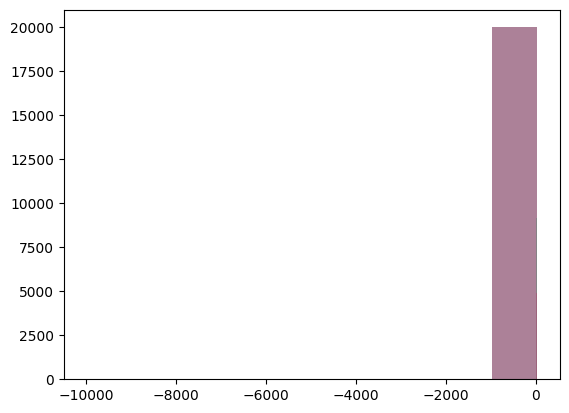

In [6]:
for col in seldf.columns:
    plt.hist(seldf[col], alpha = 0.5)

When a histogram looks like this, what does it mean?

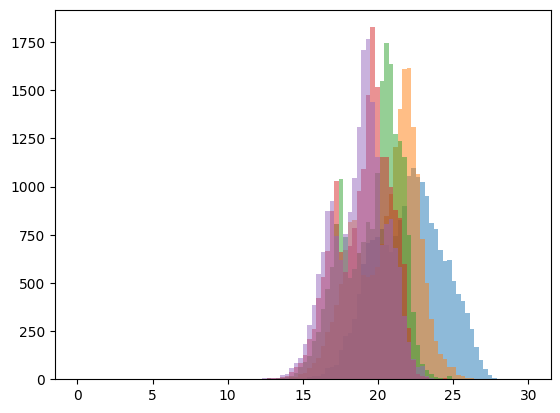

In [7]:
for col in seldf.columns:
    plt.hist(seldf[col], alpha = 0.5, bins=100, range = (0,30))

In [8]:
for col in seldf.columns:
    print(len(np.where(seldf[col] < 0)[0]))

1
1
0
0
1


One possible (less than ideal) selection:

In [9]:
for col in seldf.columns:
    seldf = seldf[seldf[col] >= 0]

In [10]:
seldf.shape 

(19999, 5)

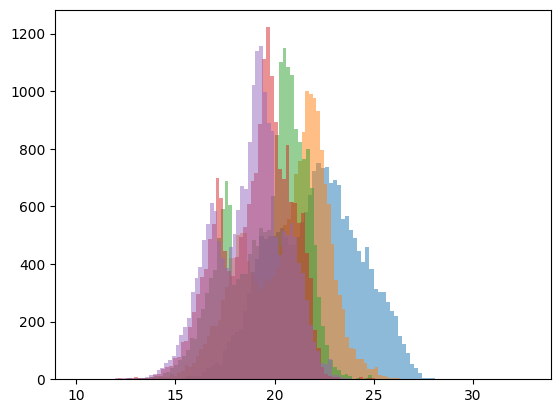

In [11]:
for col in seldf.columns:
    plt.hist(seldf[col], alpha = 0.5, bins=100)

Let's now turn to the target column.

In [12]:
np.unique(df['class'])

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() #turns categorical into 1 ... N

In [16]:
y = le.fit_transform(df['class'].values)

In [17]:
le.classes_

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

It is also useful to know which class was mapped to which number!

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'GALAXY': 0, 'QSO': 1, 'STAR': 2}


In [19]:
np.unique(y)

array([0, 1, 2])

We can now plot the class distribution to see if something stands out.

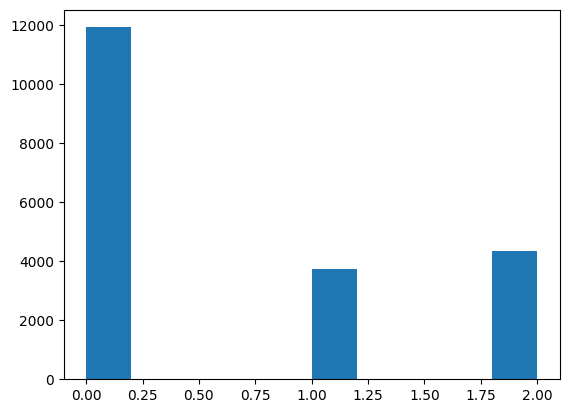

In [21]:
plt.hist(y);

Verdict: Is there anything we should keep in mind?

In [22]:
target = y[seldf.index]

Now that we have our feature matrix and target vector, we could try and build a model, or try to get some more intel on the relationship between features and target. One way is to build a correlation matrix (easiest with seaborn); another one that I like when there are very few features like in this case, is to make scatter plots of the features and color the points by the label, to see if any obvious gradient shows up. 

In [23]:
len(seldf.columns)

5

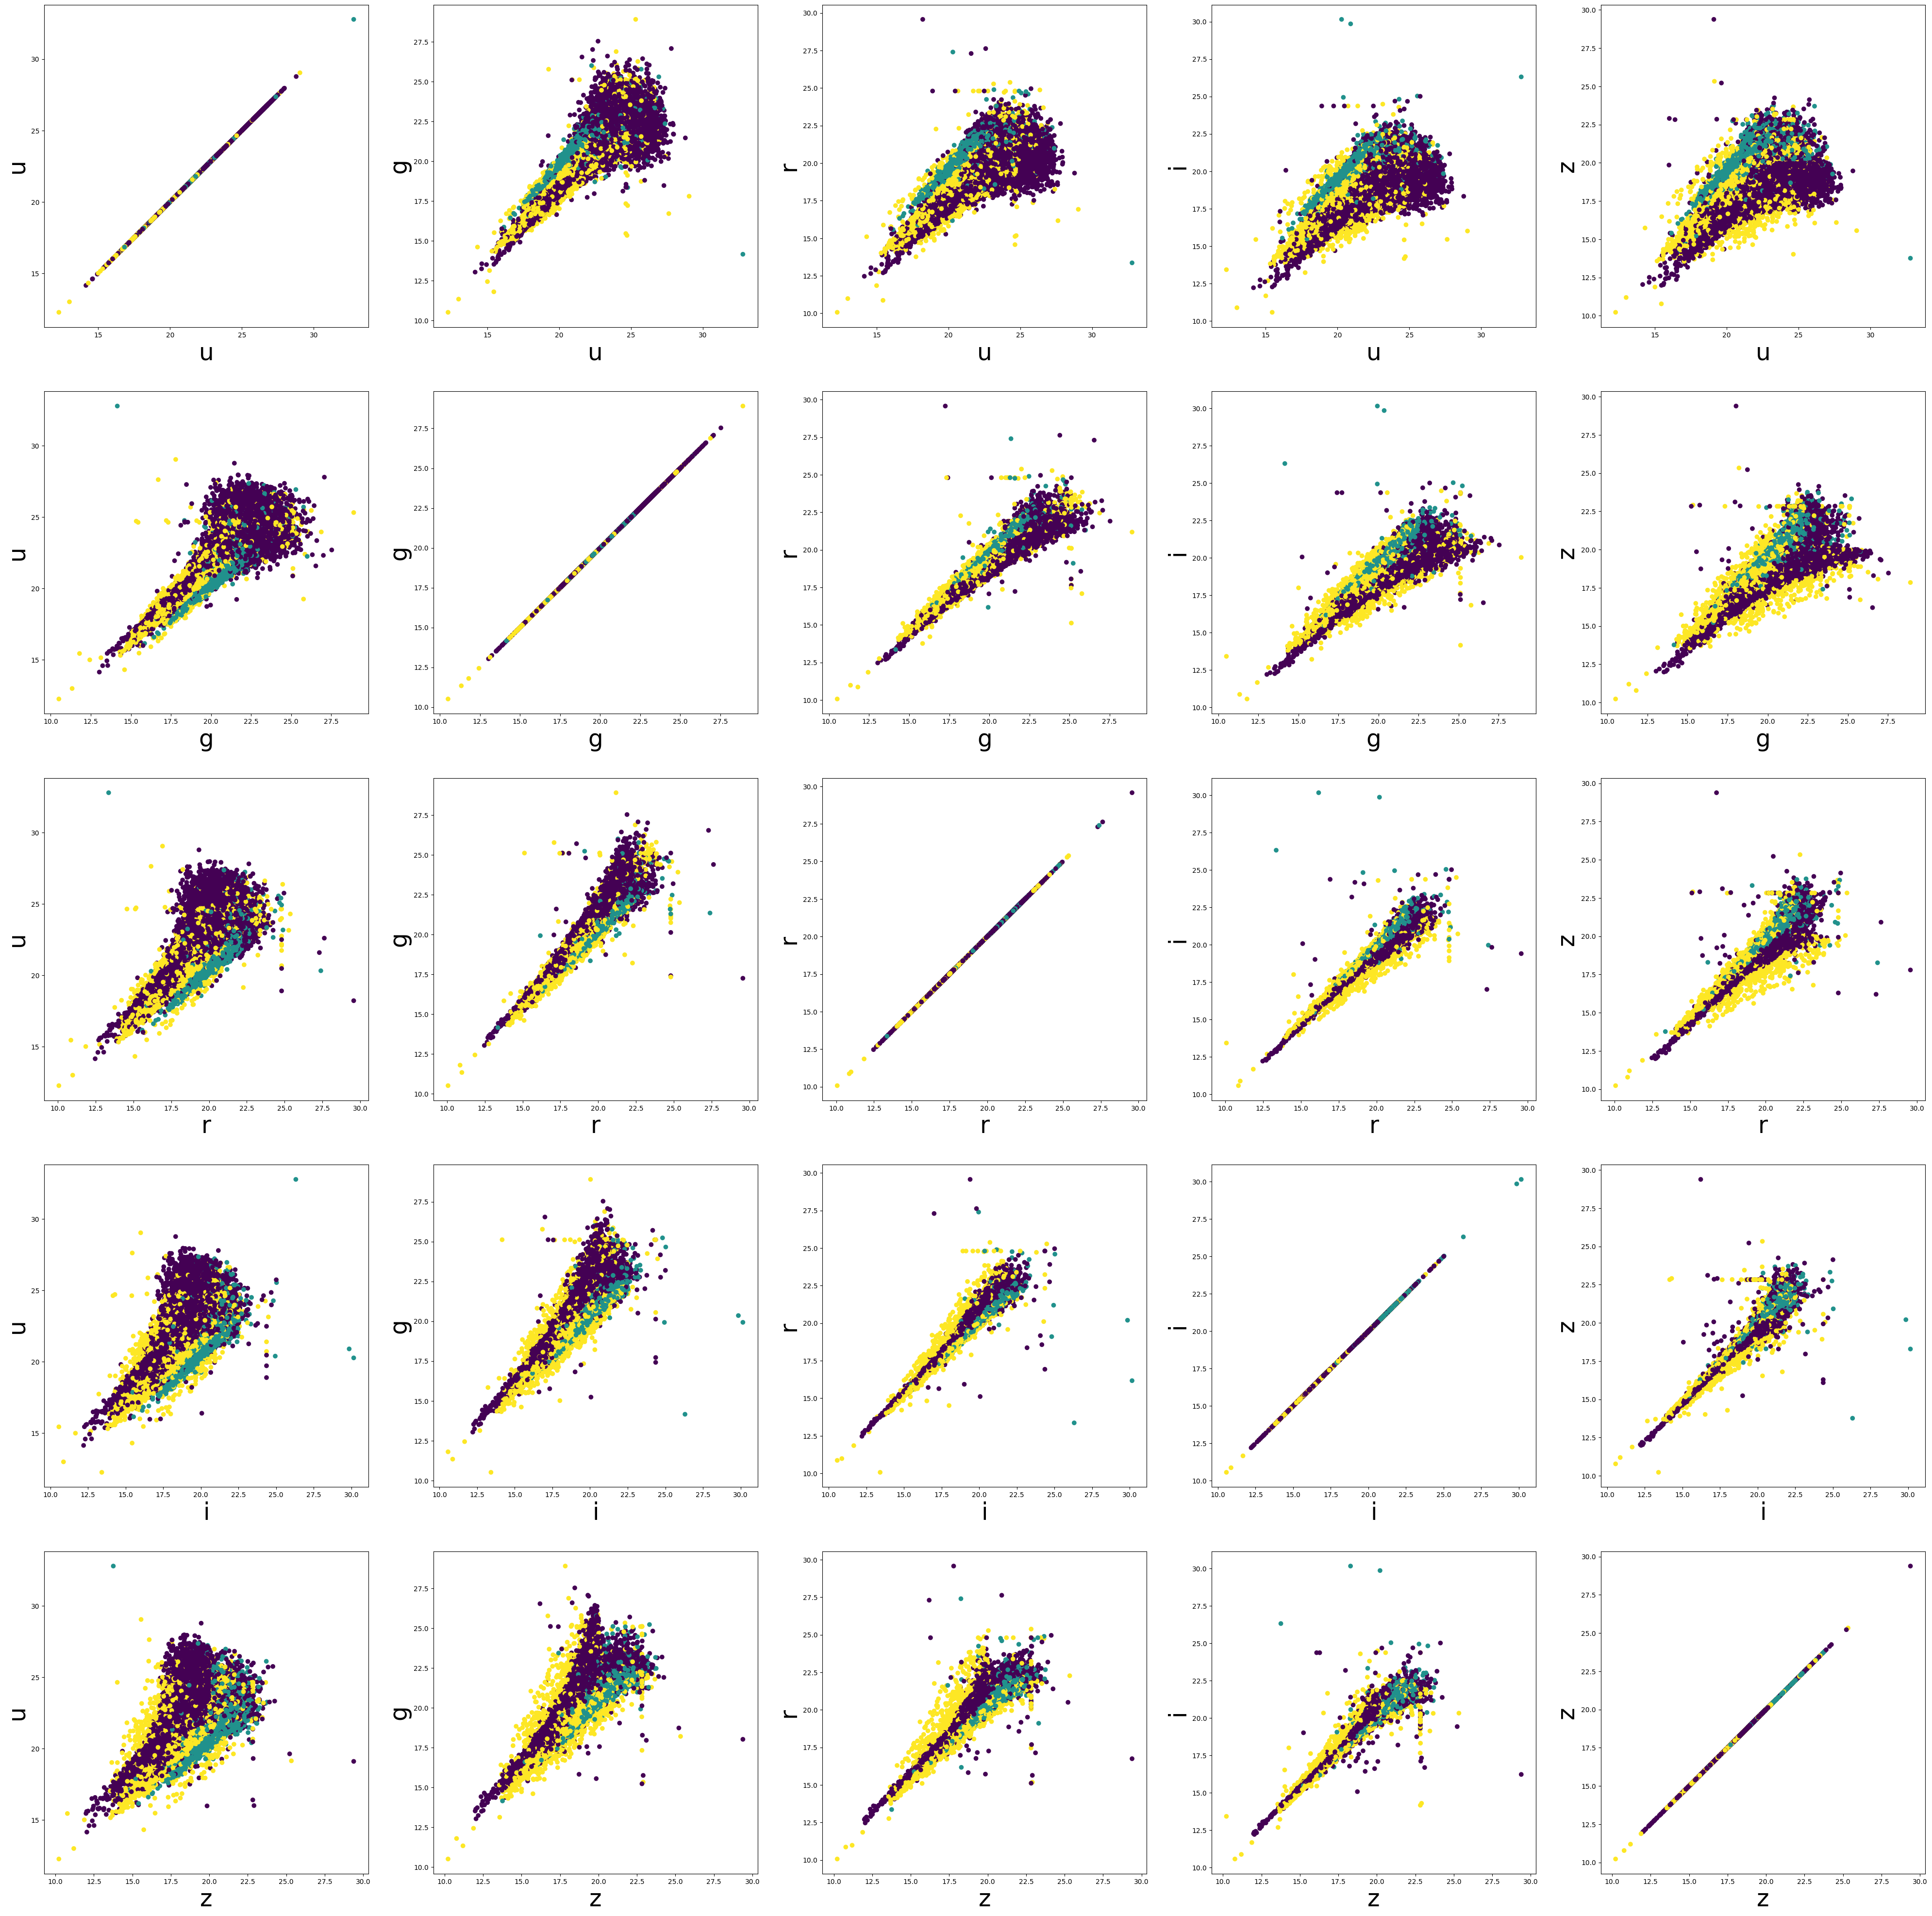

In [24]:
#It will take a little time.

fig, axes = plt.subplots(ncols = len(seldf.columns), nrows = len(seldf.columns), figsize=(50,50))

for i, col in enumerate(seldf.columns):
    for j, col2 in enumerate(seldf.columns):
        axes[i,j].scatter(seldf[col], seldf[col2], c = target)
        axes[i,j].set_xlabel(str(seldf[col].name), fontsize = 35)
        axes[i,j].set_ylabel(str(seldf[col2].name), fontsize = 35)

Q: Is there anything special that we can learn from these plots? Do we expect our features to have enough discriminating power? Why or why not?








### Building models

Alright, time to build our first model - let's start with kNN.

This line helps visualize the parameters of any algorithm.

In [37]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

We can set up a cross validation strategy like this.

In [147]:
cv = KFold(n_splits=7, random_state=10, shuffle= True)

This line does the cross validation for us by randomizing the data, creating five folds, building 5 models with the 5 possible training sets, applying each model to the objects in the test fold, and saving the 5 train and test scores in a dictionary.

In [177]:
seldf

,u,g,r,i,z,u-g,u-r,u-i,u-z
0,22.56366,22.30574,20.71001,19.60254,19.29095,0.25792,1.85365,2.96112,3.27271
1,21.61265,21.52663,21.06938,21.09617,20.68413,0.08602,0.54327,0.51648,0.92852
2,21.77360,20.60026,20.68102,20.81975,20.79408,1.17334,1.09258,0.95385,0.97952
3,19.17278,17.70152,16.99073,16.57557,16.32981,1.47126,2.18205,2.59721,2.84297
4,26.46931,20.59701,18.95319,18.31693,17.91509,5.87230,7.51612,8.15238,8.55422
...,...,...,...,...,...,...,...,...,...
19995,23.93962,21.90381,20.23260,19.26725,18.71285,2.03581,3.70702,4.67237,5.22677
19996,18.08581,17.40046,17.18425,17.01572,16.92474,0.68535,0.90156,1.07009,1.16107
19997,20.89581,20.22679,19.25845,18.84204,18.48117,0.66902,1.63736,2.05377,2.41464
19998,19.30556,18.39668,18.11955,17.99653,17.97352,0.90888,1.18601,1.30903,1.33204


In [178]:
seldf['u-g'] = seldf['u']-seldf['g']
seldf['u-r'] = seldf['u']-seldf['r']
seldf['u-i'] = seldf['u']-seldf['i']
seldf['u-z'] = seldf['u']-seldf['z']

seldf['g-r'] = seldf['g']-seldf['r']
seldf['g-i'] = seldf['g']-seldf['i']
seldf['g-z'] = seldf['g']-seldf['z']

seldf['r-i'] = seldf['r']-seldf['i']
seldf['r-z'] = seldf['r']-seldf['z']

seldf['i-z'] = seldf['i']-seldf['z']



In [179]:
seldf

,u,g,r,i,z,u-g,u-r,u-i,u-z,g-r,g-i,g-z,r-i,r-z,i-z
0,22.56366,22.30574,20.71001,19.60254,19.29095,0.25792,1.85365,2.96112,3.27271,1.59573,2.70320,3.01479,1.10747,1.41906,0.31159
1,21.61265,21.52663,21.06938,21.09617,20.68413,0.08602,0.54327,0.51648,0.92852,0.45725,0.43046,0.84250,-0.02679,0.38525,0.41204
2,21.77360,20.60026,20.68102,20.81975,20.79408,1.17334,1.09258,0.95385,0.97952,-0.08076,-0.21949,-0.19382,-0.13873,-0.11306,0.02567
3,19.17278,17.70152,16.99073,16.57557,16.32981,1.47126,2.18205,2.59721,2.84297,0.71079,1.12595,1.37171,0.41516,0.66092,0.24576
4,26.46931,20.59701,18.95319,18.31693,17.91509,5.87230,7.51612,8.15238,8.55422,1.64382,2.28008,2.68192,0.63626,1.03810,0.40184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,23.93962,21.90381,20.23260,19.26725,18.71285,2.03581,3.70702,4.67237,5.22677,1.67121,2.63656,3.19096,0.96535,1.51975,0.55440
19996,18.08581,17.40046,17.18425,17.01572,16.92474,0.68535,0.90156,1.07009,1.16107,0.21621,0.38474,0.47572,0.16853,0.25951,0.09098
19997,20.89581,20.22679,19.25845,18.84204,18.48117,0.66902,1.63736,2.05377,2.41464,0.96834,1.38475,1.74562,0.41641,0.77728,0.36087
19998,19.30556,18.39668,18.11955,17.99653,17.97352,0.90888,1.18601,1.30903,1.33204,0.27713,0.40015,0.42316,0.12302,0.14603,0.02301


In [136]:
scores = cross_validate(model, seldf, target, cv = cv, return_train_score = True)

In [137]:
print("Time: %.3fs, Mean train score: %.3f, Mean test score: %.3f, std: %.3f"%(scores['score_time'].mean(), scores['train_score'].mean(), scores['test_score'].mean(), scores['test_score'].std()))

Time: 0.001s, Mean train score: 1.000, Mean test score: 0.799, std: 0.002


Let us now set up a decision tree classifier with default parameters:

In [138]:
model = DecisionTreeClassifier(class_weight={0:np.sum(y==0)/len(y),
                                             1:np.sum(y==1)/len(y),
                                             2:np.sum(y==2)/len(y)})

In [139]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': {0: 0.59645, 1: 0.18685, 2: 0.2167},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Decision trees are more complex than kNN and have a few more hyperparameters to play with. They include: 
- the minimum number of instances in a leaf node; 
- the minimum number of instances required in a split node;
- the maximum depth of tree;
- the minimum information gain required to decide whether a split is "worth it".

In [140]:
scores = cross_validate(model, seldf, target, cv = cv, return_train_score=True)

In [141]:
print("Time: %.3fs, Mean train score: %.3f, Mean test score: %.3f, std: %.3f"%(scores['score_time'].mean(), scores['train_score'].mean(), scores['test_score'].mean(), scores['test_score'].std()))

Time: 0.001s, Mean train score: 1.000, Mean test score: 0.798, std: 0.005


Before sending you on your way with optimizing these models, let's also talk about the great function cross_val_predict. It is used to generate test predictions in the cross validation framework. Just like cross_validate, this line will randomize the data, create five folds (if the random seed is fixed, they will be consistent across our notebooks!), build 5 models with the 5 possible training sets, apply each model to the objects in the test fold, and compile together the predicted values from the 5 test folds. The output will be this vector of predicted values, which has the same size as the target vector.

In [142]:
ypred = cross_val_predict(model, seldf, target, cv = cv)

Having these predictions is very useful because you can calculate more complex scores, or a confusion matrix (or a scatter plot of true vs predicted values in the case of regression).

In [143]:
print(metrics.confusion_matrix(target, ypred))

[[10420   602   907]
 [  595  2618   524]
 [  854   539  2940]]


Finally, I'm going to drop here this handy function to calculate and plot learning curves.

Learning curves are helpful in order to visualize the training scores vs the test scores, and how they vary as a function of data set size. They allow us to determine whether we have enough learning data, AND whether we have a high bias or high variance problem.

The source code below is a slight modification of [this code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

In [144]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(str(scoring))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from cross-validation")

    plt.legend(loc="best")
    return plt

This is a demonstration of how to use the function:

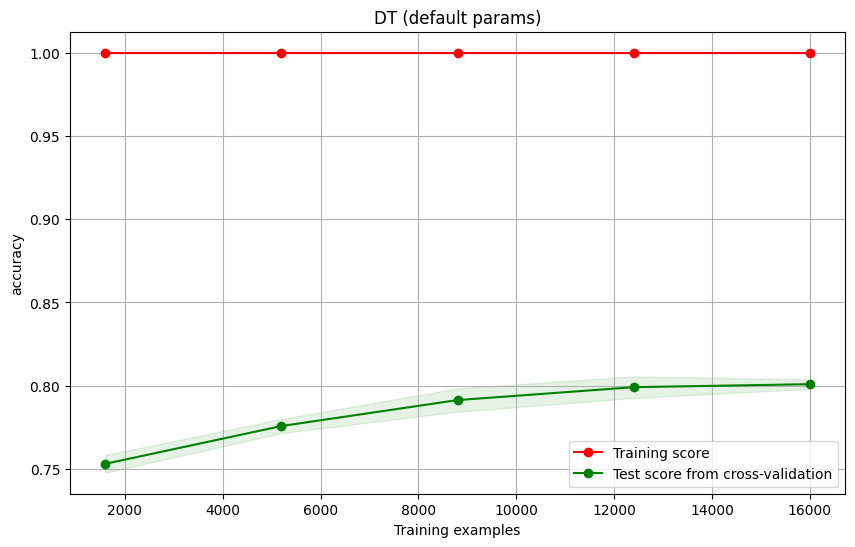

In [145]:
model = DecisionTreeClassifier(class_weight={0:np.sum(y==0)/len(y),
                                             1:np.sum(y==1)/len(y),
                                             2:np.sum(y==2)/len(y)},
                               criterion='entropy'
                               )

plot_learning_curve(model, 'DT (default params)', seldf, target,  cv = cv);

In the case, above, would we say that

- We have high bias or high variance? Why?

- We have enough training data or not? Why?

### Tasks

Feel free to do the ones you prefer according to your expertise level and personal preference!

1. Consider (separately) the kNN and DT models with default parameters. Do they suffer from high variance or high bias? Why?

2. Based on your answer above, do you anticipate better results from making the model(s) more complex or simpler? How could this be implemented, in terms of choosing hyperparameters and their range?

3. Play around with hyperparameters for a model of your choice and see what test scores you can get! The highest score wins... a drink of their choice at Monday's dinner?

4. What's something I should have done for kNN and didn't? :) 

In [163]:
from sklearn.model_selection import GridSearchCV

In [185]:
leaf_size = list(range(1,15))
n_neighbors = list(range(1,10))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size,n_neighbors=n_neighbors,p=p) 

knn_2 = KNeighborsClassifier(n_jobs=-1,weights='distance')

clf = GridSearchCV(knn_2,hyperparameters,cv=cv)

best_model = clf.fit(seldf,target)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


Best leaf_size: 1
Best p: 1
Best n_neighbors: 7


{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
[[11151   328   450]
 [  428  2900   409]
 [  749   404  3180]]
Time: 0.310s, Mean train score: 1.000, Mean test score: 0.862, std: 0.002


/home/vwetzell/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vwetzell/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vwetzell/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/vwetzell/anaconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"

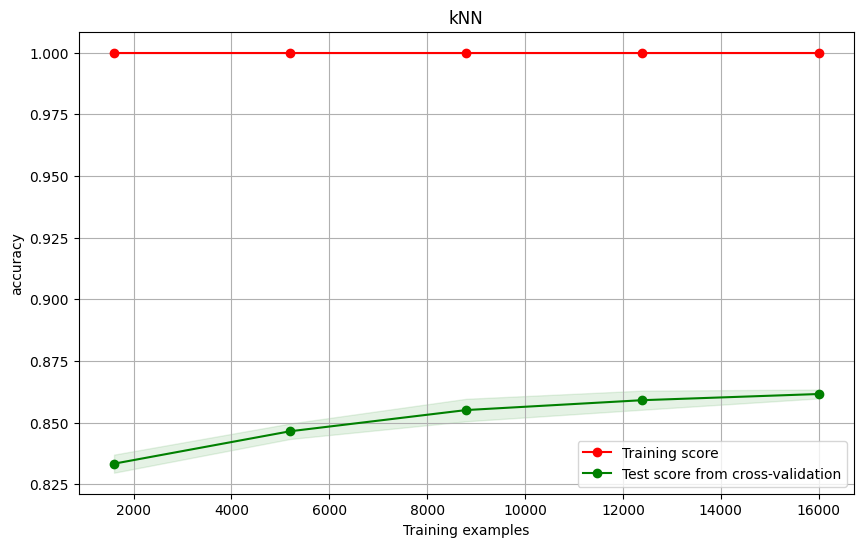

In [186]:
cv = KFold(n_splits=5, random_state=10, shuffle= True)

model_knn = KNeighborsClassifier(
    n_neighbors=7,
    leaf_size=1,
    weights='distance',
    algorithm='auto',
    p=1
)

print(model_knn.get_params())

scores_knn = cross_validate(model_knn, seldf, target, cv = cv, return_train_score=True)

ypred_knn = cross_val_predict(model_knn, seldf, target, cv = cv)

print(metrics.confusion_matrix(target, ypred_knn))

print("Time: %.3fs, Mean train score: %.3f, Mean test score: %.3f, std: %.3f"%(scores_knn['score_time'].mean(),
                                                                               scores_knn['train_score'].mean(),
                                                                               scores_knn['test_score'].mean(),
                                                                               scores_knn['test_score'].std()))

plot_learning_curve(model_knn, 'kNN', seldf, target,  cv = cv);